In [2]:
from credmark.cmf.ipython import create_cmf
from web3 import HTTPProvider, Web3

from curve_pool import CurveStableSwap
from curve_poolGamma import CurveStableSwapGamma

LINK = '0xF178C0b5Bb7e7aBF4e12A4838C7b7c5bA2C623c0'
STETH = '0xDC24316b9AE028F1497c275EB9192a3Ea0f67022'
FRAXUSDC = '0xdcef968d416a41cdac0ed8702fac8128a64241a2'
EURT = '0xfd5db7463a3ab53fd211b4af195c5bccc1a03890'
CVXETH = '0xb576491f1e6e5e62f1d8f26062ee822b40b0e0d4'

THREE_POOL = '0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7'
tricrypto2 = '0xd51a44d3fae010294c616388b506acda1bfaae46'

## Initialize CMF

In [3]:
end_block = 16024367

cmf_param = {
                'block_number': end_block,
                'chain_to_provider_url': {'1': 'http://192.168.68.122:8545'},
                'api_url': 'http://192.168.68.122:8700'
            }

context, _model_loader = create_cmf(cmf_param)
context._web3 = Web3(HTTPProvider(context.web3.provider.endpoint_uri, request_kwargs={'timeout': 3600 * 10}))
context._web3.eth.default_block = int(context.block_number)
end_block = int(context.block_number)

## Curve Sim

In [4]:
three_pool = CurveStableSwap(THREE_POOL)

print(three_pool.balances, three_pool.scaled_balances, three_pool.coins_symbol)

122990396.144477 / 124696977.35454, 124696977.35454 / 445168161.909913

0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7 for 3 coins loaded
[122990396144476991977172886, 124696977354540, 445168161909913] [122990396.144477, 124696977.35454, 445168161.909913] ['DAI', 'USDC', 'USDT']


(0.9863141733964341, 0.28011207454628)

In [70]:
# USDT has about 3 time to DAI/USDC
# We simulate for 1) USDT continue to fill up the pool, and 2) USDT back to balance

# 445168161909913 = three_pool.coins[2].scaled(445168161909913), about 445m
# use 1m as one exchange size

dx_amount = 1_000_000 * 10 ** three_pool.coins[2].decimals

xps20 = []
xps10 = []
price20 = []
price10 = []

xp = three_pool.balances
while True:
    if xp[0] > 1000:
        tok0_out = three_pool.get_dy_dx0_xp0(2, 0, dx_amount, xp)
        xps20.append([three_pool.coins[i].scaled(v) for i, v in enumerate(xp.copy())])
        ratio20 = three_pool.coins[0].scaled(tok0_out) / three_pool.coins[2].scaled(dx_amount)
        price20.append(ratio20)
        xp[0] -= tok0_out
        xp[2] += dx_amount

    if xp[1] > 1000:
        tok1_out = three_pool.get_dy_dx0_xp0(2, 1, dx_amount, xp)
        xps10.append([three_pool.coins[i].scaled(v) for i, v in enumerate(xp.copy())])
        ratio10 = three_pool.coins[1].scaled(tok1_out) / three_pool.coins[2].scaled(dx_amount)
        price10.append(ratio20)
        xp[1] -= tok1_out
        xp[2] += dx_amount

    ratio_20 = three_pool.coins[2].scaled(xp[2]) / three_pool.coins[0].scaled(xp[0])
    ratio_21 = three_pool.coins[2].scaled(xp[2]) / three_pool.coins[1].scaled(xp[1])
    ratio_2torest = three_pool.coins[2].scaled(xp[2]) / sum([three_pool.coins[i].scaled(xp[i]) for i in range(3)])

    # print(xp, ratio_20, ratio_21)
    
    if ratio_2torest > 0.99:
        break

    if (xp[0] <= 1000 and xp[1] <= 1000):
        break

    if len(xps10) > 110:
        break    

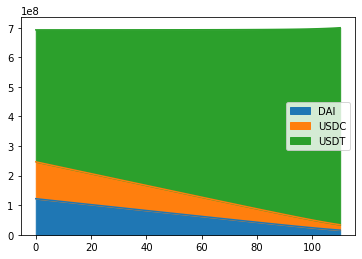

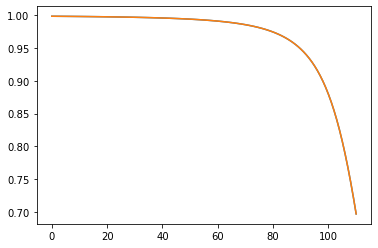

In [72]:
df = pd.DataFrame(xps10, columns=three_pool.coins_symbol)

df.plot.area(); plt.show()

plt.plot(price10); plt.plot(price20); plt.show()

In [73]:
# USDT has about 3 time to DAI/USDC
# We simulate for 1) USDT continue to fill up the pool, and 2) USDT back to balance

# 445168161909913 = three_pool.coins[2].scaled(445168161909913), about 445m
# use 1m as one exchange size

dx0_amount = 1_000_000 * 10 ** three_pool.coins[0].decimals
dx1_amount = 1_000_000 * 10 ** three_pool.coins[1].decimals

xps20 = []
xps10 = []
price20 = []
price10 = []

xp = three_pool.balances
while True:
    if xp[0] > 1000:
        tok2_out = three_pool.get_dy_dx0_xp0(0, 2, dx0_amount, xp)
        xps20.append([three_pool.coins[i].scaled(v) for i, v in enumerate(xp.copy())])
        ratio20 = three_pool.coins[2].scaled(tok2_out) / three_pool.coins[0].scaled(dx0_amount)
        price20.append(ratio20)
        xp[0] += dx0_amount
        xp[2] -= tok2_out

    if xp[1] > 1000:
        tok2_out = three_pool.get_dy_dx0_xp0(1, 2, dx1_amount, xp)
        xps10.append([three_pool.coins[i].scaled(v) for i, v in enumerate(xp.copy())])
        ratio10 = three_pool.coins[2].scaled(tok2_out) / three_pool.coins[1].scaled(dx1_amount)
        price10.append(ratio20)
        xp[1] += dx1_amount
        xp[2] -= tok2_out

    ratio_20 = three_pool.coins[2].scaled(xp[2]) / three_pool.coins[0].scaled(xp[0])
    ratio_21 = three_pool.coins[2].scaled(xp[2]) / three_pool.coins[1].scaled(xp[1])
    ratio_2torest = three_pool.coins[2].scaled(xp[2]) / sum([three_pool.coins[i].scaled(xp[i]) for i in range(3)])

    # print(xp, ratio_20, ratio_21)
    
    if ratio_2torest > 0.99:
        break

    if (xp[0] <= 1000 and xp[1] <= 1000):
        break

    if len(xps10) > 110:
        break    

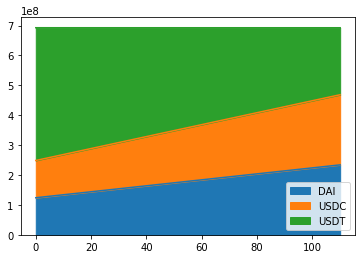

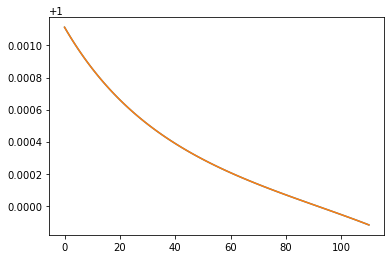

In [74]:
df = pd.DataFrame(xps10, columns=three_pool.coins_symbol)

df.plot.area(); plt.show()

plt.plot(price10); plt.plot(price20); plt.show()